# Plot LRG HOD fitsigmas chains
This jupyter notebook contains some code to make plots of the bestfits and contours for Sigma_nl's and Sigma_s for the abacus cubic LRG fits. It can be placed inside the same code as used to perform the fits, but here has been placed inside a separate Jupyter notebook to allow for real-time viewing of the plots. The only difference is that we have to read in a pickle dump of all the fitter information, which is the plotting was in the same code as the fitting we would not have to do.

In [1]:
# Import some necessary modules
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     

sys.path.append("../../../Barry/")     # Change this so that it points to where you have Barry installed

from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction
from barry.utils import weighted_avg_and_cov

# Read in the fitter class to get all the info on the fit
pfn = "./plots/desi_kp4_abacus_cubic_LRG_HOD_fitsigmas/output/desi_kp4_abacus_cubic_LRG_HOD_fitsigmas.fitter.pkl"
with open(pfn, 'rb') as pickle_file:
    fitter = pickle.load(pickle_file)

This code segment reads in the chains, plots the bestfit model vs. data and produces a contour plot.

In [2]:
logging.info("Creating plots")

datanames = ["Xi_Prerecon", "Xi_Postrecon", "Pk_Prerecon", "Pk_Postrecon"]

# Set up separate chainconsumer instances for Xi and Pk, Pre and Post recon. We'll plot the 8 HODs for each on the same contour plot
c = [ChainConsumer(), ChainConsumer(), ChainConsumer(), ChainConsumer()]

# Loop over all the chains
output = {k: [] for k in datanames}
for posterior, weight, chain, evidence, model, data, extra in fitter.load():

    # Get the HOD number from the fit name
    data_bin = 0 if "Xi" in extra["name"] else 1
    recon_bin = 0 if "Prerecon" in extra["name"] else 1
    hod_bin = int(extra["name"].split('HOD')[1][0])
    chain_bin = int(2.0 * data_bin + recon_bin)
    print(extra["name"], data_bin, recon_bin, hod_bin)
    
    # Store the chain in a dictionary with parameter names
    df = pd.DataFrame(chain, columns=model.get_labels())

    # Get the MAP point and set the model up at this point
    model.set_data(data)
    r_s = model.camb.get_data()["r_s"]
    max_post = posterior.argmax()
    params = df.loc[max_post]
    params_dict = model.get_param_dict(chain[max_post])
    for name, val in params_dict.items():
        model.set_default(name, val)

    # Get some useful properties of the fit, and plot the MAP model against the data. Plot the fit for HOD 4
    display = True if hod_bin == 4 or hod_bin == 0 else False
    new_chi_squared, dof, bband, mods, smooths = model.plot(params_dict, display=False)

    # Add the chain to Chainconsumer and plot
    extra.pop("realisation", None)
    extra.pop('name', None)
    c[chain_bin].add_chain(df, weights=weight, **extra, name=f'HOD{hod_bin}', plot_contour=True, plot_point=False, show_as_1d_prior=False)
    
    # Compute some summary statistics and add them to a dictionary
    mean, cov = weighted_avg_and_cov(
        df[["$\\Sigma_{nl,||}$", "$\\Sigma_{nl,\\perp}$", "$\\Sigma_s$"]],
        weight,
        axis=0,
    )

    output[datanames[chain_bin]].append(
        f"{hod_bin:3d}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {np.sqrt(cov[2, 2]):6.4f}, {new_chi_squared:7.3f}, {dof:4d}"
    )

DESI KP4 Abacus CubicBox Pk LRG HOD0 Prerecon mock mean 1 0 0
DESI KP4 Abacus CubicBox Pk LRG HOD0 Recon mock mean 1 1 0
DESI KP4 Abacus CubicBox Pk LRG HOD1 Prerecon mock mean 1 0 1
DESI KP4 Abacus CubicBox Pk LRG HOD1 Recon mock mean 1 1 1
DESI KP4 Abacus CubicBox Pk LRG HOD2 Prerecon mock mean 1 0 2
DESI KP4 Abacus CubicBox Pk LRG HOD2 Recon mock mean 1 1 2
DESI KP4 Abacus CubicBox Pk LRG HOD3 Prerecon mock mean 1 0 3
DESI KP4 Abacus CubicBox Pk LRG HOD3 Recon mock mean 1 1 3
DESI KP4 Abacus CubicBox Pk LRG HOD4 Prerecon mock mean 1 0 4
DESI KP4 Abacus CubicBox Pk LRG HOD4 Recon mock mean 1 1 4
DESI KP4 Abacus CubicBox Pk LRG HOD5 Prerecon mock mean 1 0 5
DESI KP4 Abacus CubicBox Pk LRG HOD5 Recon mock mean 1 1 5
DESI KP4 Abacus CubicBox Pk LRG HOD6 Prerecon mock mean 1 0 6
DESI KP4 Abacus CubicBox Pk LRG HOD6 Recon mock mean 1 1 6
DESI KP4 Abacus CubicBox Pk LRG HOD7 Prerecon mock mean 1 0 7
DESI KP4 Abacus CubicBox Pk LRG HOD7 Recon mock mean 1 1 7
DESI KP4 Abacus CubicBox Pk LRG 

Xi_Prerecon


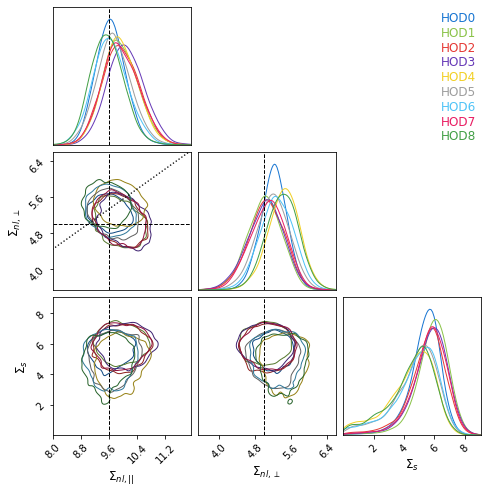

Xi_Postrecon


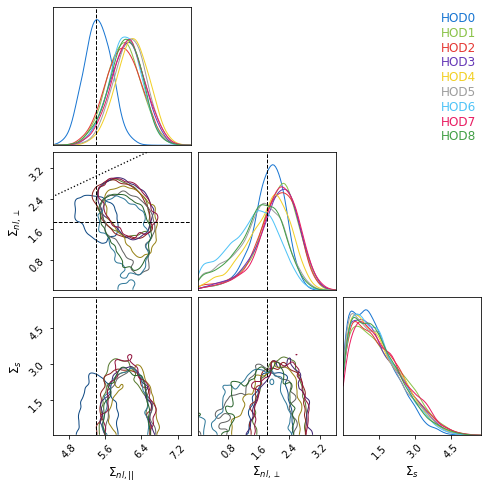

Pk_Prerecon


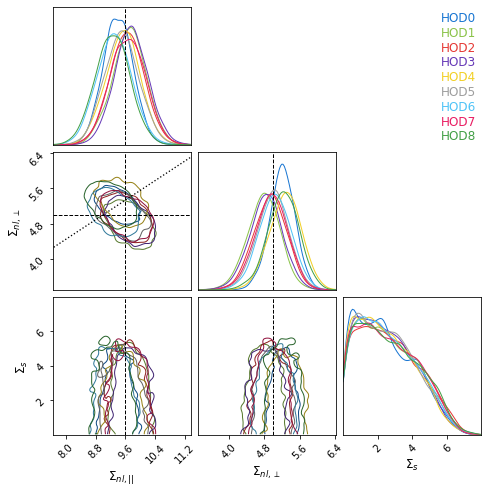

Pk_Postrecon


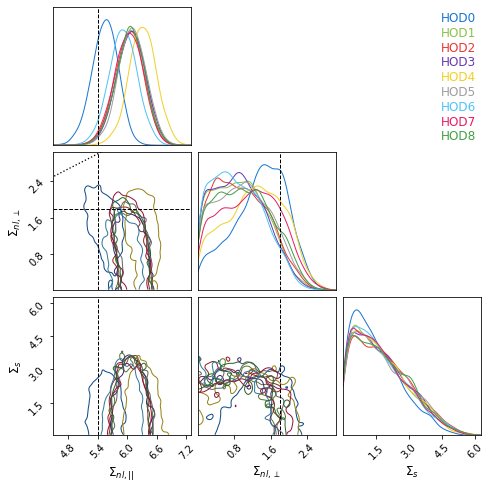

In [3]:
for chain_bin in range(len(c)):
    print(datanames[chain_bin])
    if "Pre" in datanames[chain_bin]:
        truth = {"$\\Sigma_{nl,||}$": 9.6, "$\\Sigma_{nl,\\perp}$": 5.0, "$\\Sigma_s$": None}
    else:
        truth = {"$\\Sigma_{nl,||}$": 5.4, "$\\Sigma_{nl,\\perp}$": 1.8, "$\\Sigma_s$": None}
    c[chain_bin].configure(bins=20, sigmas=[1])
    fig = c[chain_bin].plotter.plot(
        parameters=["$\\Sigma_{nl,||}$", "$\\Sigma_{nl,\\perp}$", "$\\Sigma_s$"],
        legend=True,
        truth=truth,
        figsize=(7,7),
    )
    xvals = np.linspace(0.0, 20.0, 100)
    fig.get_axes()[3].plot(xvals, xvals / (1.0 + 0.8), color="k", linestyle=":", linewidth=1.3)
    plt.show()
    
    # Save all the numbers to a file
    with open("./plots/desi_kp4_abacus_cubic_LRG_HOD_fitsigmas/output/Barry_fit_" + datanames[chain_bin] + ".txt", "w") as f:
        f.write(
            "# HOD, Sigma_nl_par, Sigma_nl_perp, Sigma_s, sigma_Sigma_nl__par, sigma_Sigma_nl_perp, sigma_Sigma_s, corr_Sigma_nl, corr_Sigma_nl_par_s, corr_Sigma_nl_perp_s, rd_of_template, bf_chi2, dof\n"
        )
        for l in output[datanames[chain_bin]]:
            f.write(l + "\n")